# Xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics

## 1. Data load

train data set 정리  
- train_origin : original train data set, f_score dataframe의 idx로 onehotencoding된 값까지 저장하기위해 사용
- train_set : features들 제거된 train data set
- train_t : validation과 나눠지기 전 train data set, 마지막 test set을 prediction 하기 전 전체 train set을 학습하기 위해 저장
- train : validation과 나눠진 후 train data set

In [2]:
train_origin = pd.read_csv('../../input/train.csv', na_values=['-1','-1.0'])
test_set = pd.read_csv('../../input/test.csv', na_values=['-1','-1.0'])

In [3]:
train_origin.shape

(595212, 59)

train_set의 origin columns를 저장하기 위해 copy

In [4]:
train_set = train_origin.copy()

## 2. Data cleaning

Mean, Medain이 차이가 없다고 생각되는 features 제외

In [5]:
# drop_feature = ['ps_ind_01', 'ps_car_11', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_03', 
#                'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08',
#                'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']
# train_set = train_set.drop(drop_feature, axis=1)
# test_set = test_set.drop(drop_feature, axis=1)

위에꺼에 binary중에 차이 없는 features까지 제외

In [6]:
# drop_feature = ['ps_ind_01', 'ps_car_11', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_03', 
#                'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08',
#                'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
#                'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_13_bin', 'ps_calc_15_bin', 'ps_calc_16_bin',
#                'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
# train_set = train_set.drop(drop_feature, axis=1)
# test_set = test_set.drop(drop_feature, axis=1)

위에꺼에 category중에 차이 없는 features까지 제외

In [7]:
drop_feature = ['ps_ind_01', 'ps_car_11', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_03', 
               'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08',
               'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
               'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_13_bin', 'ps_calc_15_bin', 'ps_calc_16_bin',
               'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin',
               'ps_car_05_cat', 'ps_car_10_cat', 'ps_car_11_cat']
train_set = train_set.drop(drop_feature, axis=1)
test_set = test_set.drop(drop_feature, axis=1)

In [8]:
train_origin.shape

(595212, 59)

In [9]:
train_set.shape

(595212, 30)

### 2.1 onehotencoding for category variables

In [10]:
def onehotencoder(df, variables):
    dummies = pd.DataFrame()
    for var in variables:
        dummy = pd.get_dummies(df[var],prefix=var)
        dummies = pd.concat([dummies,dummy],axis=1)
        df = df.drop(var, axis=1)
    df = pd.concat([df,dummies],axis=1)
    
    return df

In [11]:
cat = [col for col in train_origin.columns if 'cat' in col]
train_origin = onehotencoder(train_origin, cat)

In [12]:
train_origin.shape

(595212, 220)

In [13]:
cat = [col for col in train_set.columns if 'cat' in col]
train_t = onehotencoder(train_set, cat)
test = onehotencoder(test_set,cat)

In [14]:
train_t.shape

(595212, 85)

## 3. Data split

train : validation = 7 : 3

In [15]:
x_data = train_t.drop(columns=['id','target'])
y_data = train_t[['target']]

test_idx = test['id']
test = test.drop(columns=['id'])

In [16]:
x_train, x_val, y_train, y_val = train_test_split(x_data,y_data,test_size=0.3,random_state=223)

In [17]:
train = pd.concat([x_train,y_train], axis=1)
val = pd.concat([x_val,y_val], axis=1)

## 4. XGboosting

In [18]:
def gini(pred, actual, cmpcol=0, sortcol=1):
    if type(actual).__module__ == 'xgboost.core':
        actual = actual.get_label()
    if type(pred).__module__ == 'xgboost.core':
        pred = pred.get_label()
    
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(p, a):
    return 'gini_normal', gini(p, a) / gini(a, a)

Parameter tuning method  
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [19]:
def modelfit(alg, dtrain, dval, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    predictors = [x for x in dtrain.columns if x not in ['id','target']]
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['target'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['target'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
      
    #Predict training set:
    dval_predictions = alg.predict(dval[predictors])
    dval_predprob = alg.predict_proba(dval[predictors])[:,1]
    
    #Print model report:
    print("\nModel Report[train data]")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['target'], dtrain_predprob))
    
    print("\nModel Report[validation data]")
    print("Accuracy : %.4g" % metrics.accuracy_score(dval['target'].values, dval_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dval['target'], dval_predprob))
    
    gini_pred = gini(dval_predprob, dval['target'])
    gini_max = gini(dval['target'], dval['target'])
    _, ngini = gini_normalized(dval_predprob, dval['target'])

    print('Gini: {0:.5f}, Max Gini: {1:.5f}, Normlization Gini: {2:.5f}'.format(gini_pred, gini_max, ngini))
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=True)
    f, ax = plt.subplots(1,1, figsize=(10,50))
    feat_imp.plot(kind='barh', title='Feature importance', ax=ax)
    ax.set_ylabel('Feature importance score')
    plt.show()
    
    return alg
    

In [20]:
def param_tune(df, param_test, xgb_param):
    predictors = [x for x in df.columns if x not in ['id','target']]
    param_test = param_test
    gsearch = GridSearchCV(estimator = xgb.XGBClassifier(**xgb_param, seed=1223), 
                            param_grid = param_test, 
                            scoring = 'roc_auc',
                            n_jobs=4,
                            iid=False,
                            verbose=2,
                            cv=5)
    gsearch.fit(df[predictors],df['target'])
    return gsearch

# 5. Parameter tuning

[0]	train-auc:0.598942+0.0018129	test-auc:0.592645+0.00588363
[1]	train-auc:0.615451+0.00249969	test-auc:0.607393+0.00626569
[2]	train-auc:0.620259+0.00122588	test-auc:0.610785+0.00589843
[3]	train-auc:0.623287+0.0020841	test-auc:0.6138+0.00603781
[4]	train-auc:0.625213+0.00131126	test-auc:0.615948+0.00582404
[5]	train-auc:0.62681+0.000730517	test-auc:0.617063+0.00583952
[6]	train-auc:0.627299+0.00099	test-auc:0.617096+0.00589514
[7]	train-auc:0.62805+0.00125651	test-auc:0.617364+0.00601045
[8]	train-auc:0.629177+0.000563908	test-auc:0.618541+0.00503501
[9]	train-auc:0.62973+0.000404521	test-auc:0.618669+0.00516224
[10]	train-auc:0.629983+0.000770067	test-auc:0.618612+0.0049331
[11]	train-auc:0.630398+0.000639186	test-auc:0.619424+0.00484447
[12]	train-auc:0.631407+0.00069741	test-auc:0.620059+0.00379664
[13]	train-auc:0.631896+0.000961679	test-auc:0.620523+0.00358521
[14]	train-auc:0.632919+0.00105574	test-auc:0.620612+0.00377625
[15]	train-auc:0.633318+0.00138016	test-auc:0.621045+0.

[127]	train-auc:0.691664+0.000884018	test-auc:0.636251+0.00447106
[128]	train-auc:0.691995+0.000912087	test-auc:0.636283+0.00450198
[129]	train-auc:0.692378+0.000878198	test-auc:0.636298+0.00449595
[130]	train-auc:0.692759+0.000865877	test-auc:0.636369+0.00458277
[131]	train-auc:0.693194+0.000867478	test-auc:0.636365+0.00445901
[132]	train-auc:0.693484+0.000792325	test-auc:0.636364+0.00449972
[133]	train-auc:0.693838+0.000846324	test-auc:0.636265+0.00449739
[134]	train-auc:0.69413+0.000823541	test-auc:0.636175+0.00449791
[135]	train-auc:0.694462+0.000838246	test-auc:0.636191+0.00458586
[136]	train-auc:0.694744+0.00089125	test-auc:0.636191+0.00452273
[137]	train-auc:0.695184+0.000853481	test-auc:0.636132+0.00445657
[138]	train-auc:0.695588+0.000990025	test-auc:0.636099+0.00438177
[139]	train-auc:0.695879+0.000964868	test-auc:0.636094+0.00443765
[140]	train-auc:0.696153+0.000997505	test-auc:0.636134+0.0043645
[141]	train-auc:0.696486+0.000992096	test-auc:0.636141+0.00433176
[142]	train-a

C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report[train data]
Accuracy : 0.9637
AUC Score (Train): 0.680109

Model Report[validation data]
Accuracy : 0.9633
AUC Score (Train): 0.642573
Gini: 0.13734, Max Gini: 0.48166, Normlization Gini: 0.28515


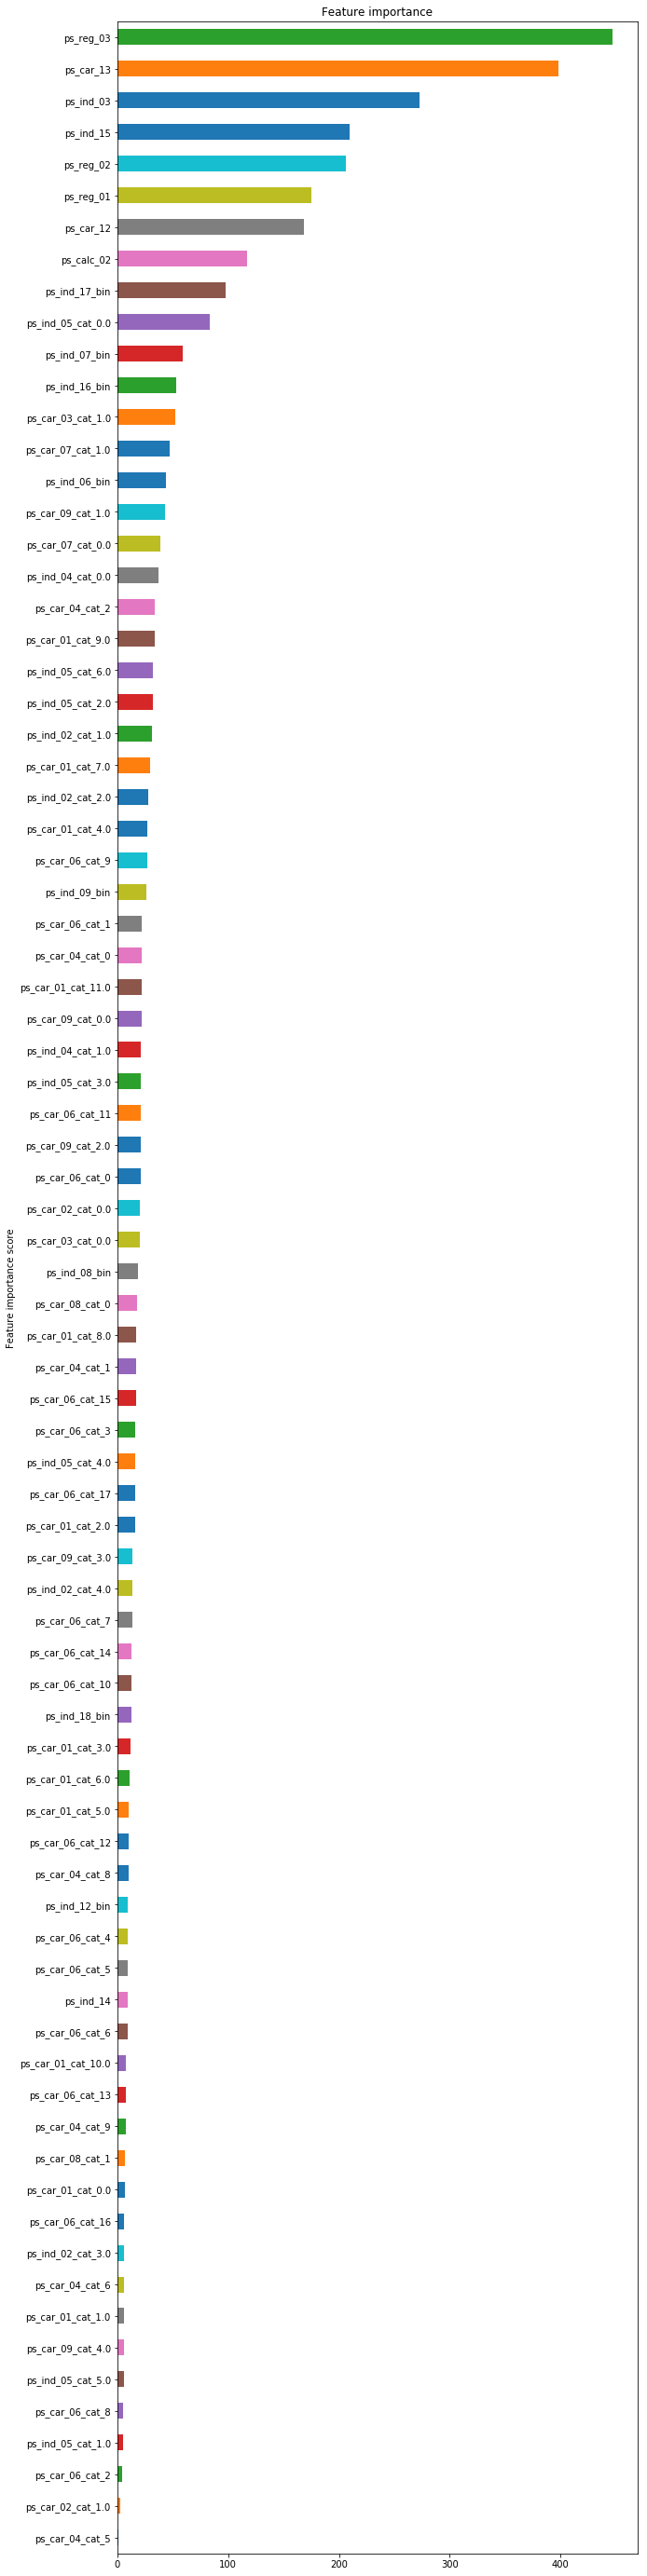

Wall time: 1min 18s


In [33]:
%%time
#Choose all predictors except target & IDcols
xgb1 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'gpu:binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    seed=1223)
alg1 = modelfit(xgb1, train, val)

# Step1

In [34]:
%%time
param_test1 = {
     'max_depth':np.arange(3,10,2),
     'min_child_weight':np.arange(1,6,2)
}

xgb_param1 = {
    'learning_rate':0.1, 
    'n_estimators':200, 
    'gamma':0, 
    'subsample':0.8, 
    'colsample_bytree':0.8,
    'objective': 'gpu:binary:logistic', 
    'nthread':4, 
    'scale_pos_weight':1, 
    'tree_method':'gpu_hist', 
    'predictor':'gpu_predictor'
}
gsearch1 = param_tune(train, param_test1, xgb_param1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed: 13.8min finished


Wall time: 13min 50s


In [35]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63732, std: 0.00341, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.63706, std: 0.00357, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.63700, std: 0.00335, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.63556, std: 0.00228, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.63489, std: 0.00318, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.63461, std: 0.00250, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.62558, std: 0.00423, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.62516, std: 0.00290, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.62710, std: 0.00298, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.60799, std: 0.00193, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.61058, std: 0.00378, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.61459, std: 0.00365, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1

In [37]:
%%time
param_test2 = {
     'max_depth': [2,3,4]
}

xgb_param2 = {
    'learning_rate':0.1, 
    'n_estimators':200, 
    'min_child_weight':1,
    'gamma':0, 
    'subsample':0.8, 
    'colsample_bytree':0.8,
    'objective': 'gpu:binary:logistic', 
    'nthread':4, 
    'scale_pos_weight':1, 
    'tree_method':'gpu_hist', 
    'predictor':'gpu_predictor'
}
gsearch2 = param_tune(train,param_test2, xgb_param2)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   25.3s remaining:   22.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   34.6s finished


Wall time: 40.8 s


In [38]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63499, std: 0.00339, params: {'max_depth': 2},
  mean: 0.63732, std: 0.00341, params: {'max_depth': 3},
  mean: 0.63671, std: 0.00241, params: {'max_depth': 4}],
 {'max_depth': 3},
 0.6373187691832332)

[0]	train-auc:0.586845+0.00208957	test-auc:0.584272+0.00606701
[1]	train-auc:0.604486+0.00360879	test-auc:0.600876+0.00643299
[2]	train-auc:0.60836+0.00162664	test-auc:0.603319+0.00575125
[3]	train-auc:0.611067+0.00126357	test-auc:0.60671+0.00510426
[4]	train-auc:0.611797+0.00100282	test-auc:0.607182+0.00537647
[5]	train-auc:0.613007+0.00105219	test-auc:0.608704+0.00579844
[6]	train-auc:0.613436+0.00108949	test-auc:0.608384+0.00542532
[7]	train-auc:0.61428+0.00123505	test-auc:0.609591+0.00582512
[8]	train-auc:0.61489+0.00085471	test-auc:0.610319+0.00502103
[9]	train-auc:0.614625+0.000782267	test-auc:0.610448+0.0055165
[10]	train-auc:0.614931+0.000913772	test-auc:0.61017+0.00533418
[11]	train-auc:0.61502+0.000899855	test-auc:0.610611+0.00565967
[12]	train-auc:0.616132+0.00160884	test-auc:0.611607+0.00466693
[13]	train-auc:0.61659+0.00169901	test-auc:0.612005+0.00445173
[14]	train-auc:0.617281+0.000776195	test-auc:0.612353+0.00509264
[15]	train-auc:0.61811+0.0013227	test-auc:0.613157+0.0

[128]	train-auc:0.652638+0.000719077	test-auc:0.636186+0.00341819
[129]	train-auc:0.652792+0.000716649	test-auc:0.636261+0.00348203
[130]	train-auc:0.65294+0.000709733	test-auc:0.636299+0.00356948
[131]	train-auc:0.65308+0.00067233	test-auc:0.636295+0.00357782
[132]	train-auc:0.653183+0.00071683	test-auc:0.636284+0.00354092
[133]	train-auc:0.653321+0.00066464	test-auc:0.636299+0.00349973
[134]	train-auc:0.653431+0.000648909	test-auc:0.636317+0.00347564
[135]	train-auc:0.6536+0.000632328	test-auc:0.636281+0.00349651
[136]	train-auc:0.653748+0.00060347	test-auc:0.636346+0.003523
[137]	train-auc:0.653891+0.000587943	test-auc:0.636344+0.00358128
[138]	train-auc:0.654004+0.000580389	test-auc:0.636323+0.00359002
[139]	train-auc:0.65411+0.000562306	test-auc:0.636377+0.00361583
[140]	train-auc:0.654243+0.000555388	test-auc:0.636381+0.00358349
[141]	train-auc:0.65436+0.000564493	test-auc:0.636355+0.00360128
[142]	train-auc:0.654478+0.000549762	test-auc:0.636343+0.00356803
[143]	train-auc:0.6545

[254]	train-auc:0.665446+0.000378094	test-auc:0.637177+0.00386687
[255]	train-auc:0.66551+0.000359059	test-auc:0.63721+0.00380735
[256]	train-auc:0.665611+0.00041509	test-auc:0.637235+0.00376262
[257]	train-auc:0.665706+0.000407312	test-auc:0.637249+0.00375908
[258]	train-auc:0.66579+0.000395714	test-auc:0.637253+0.0037515
[259]	train-auc:0.665892+0.000409631	test-auc:0.63722+0.00372603
[260]	train-auc:0.666013+0.000402772	test-auc:0.637244+0.00370251
[261]	train-auc:0.66607+0.000406502	test-auc:0.637238+0.00365584
[262]	train-auc:0.666172+0.00039017	test-auc:0.637201+0.00362841
[263]	train-auc:0.666256+0.000366524	test-auc:0.637168+0.00363847
[264]	train-auc:0.666351+0.000344351	test-auc:0.637191+0.00363266
[265]	train-auc:0.666431+0.000330321	test-auc:0.637132+0.00359435
[266]	train-auc:0.66653+0.000323213	test-auc:0.637152+0.00361423
[267]	train-auc:0.66662+0.000334414	test-auc:0.637204+0.00361327
[268]	train-auc:0.666664+0.000348371	test-auc:0.637189+0.00360207
[269]	train-auc:0.66

C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report[train data]
Accuracy : 0.9637
AUC Score (Train): 0.659415

Model Report[validation data]
Accuracy : 0.9633
AUC Score (Train): 0.642482
Gini: 0.13726, Max Gini: 0.48166, Normlization Gini: 0.28496


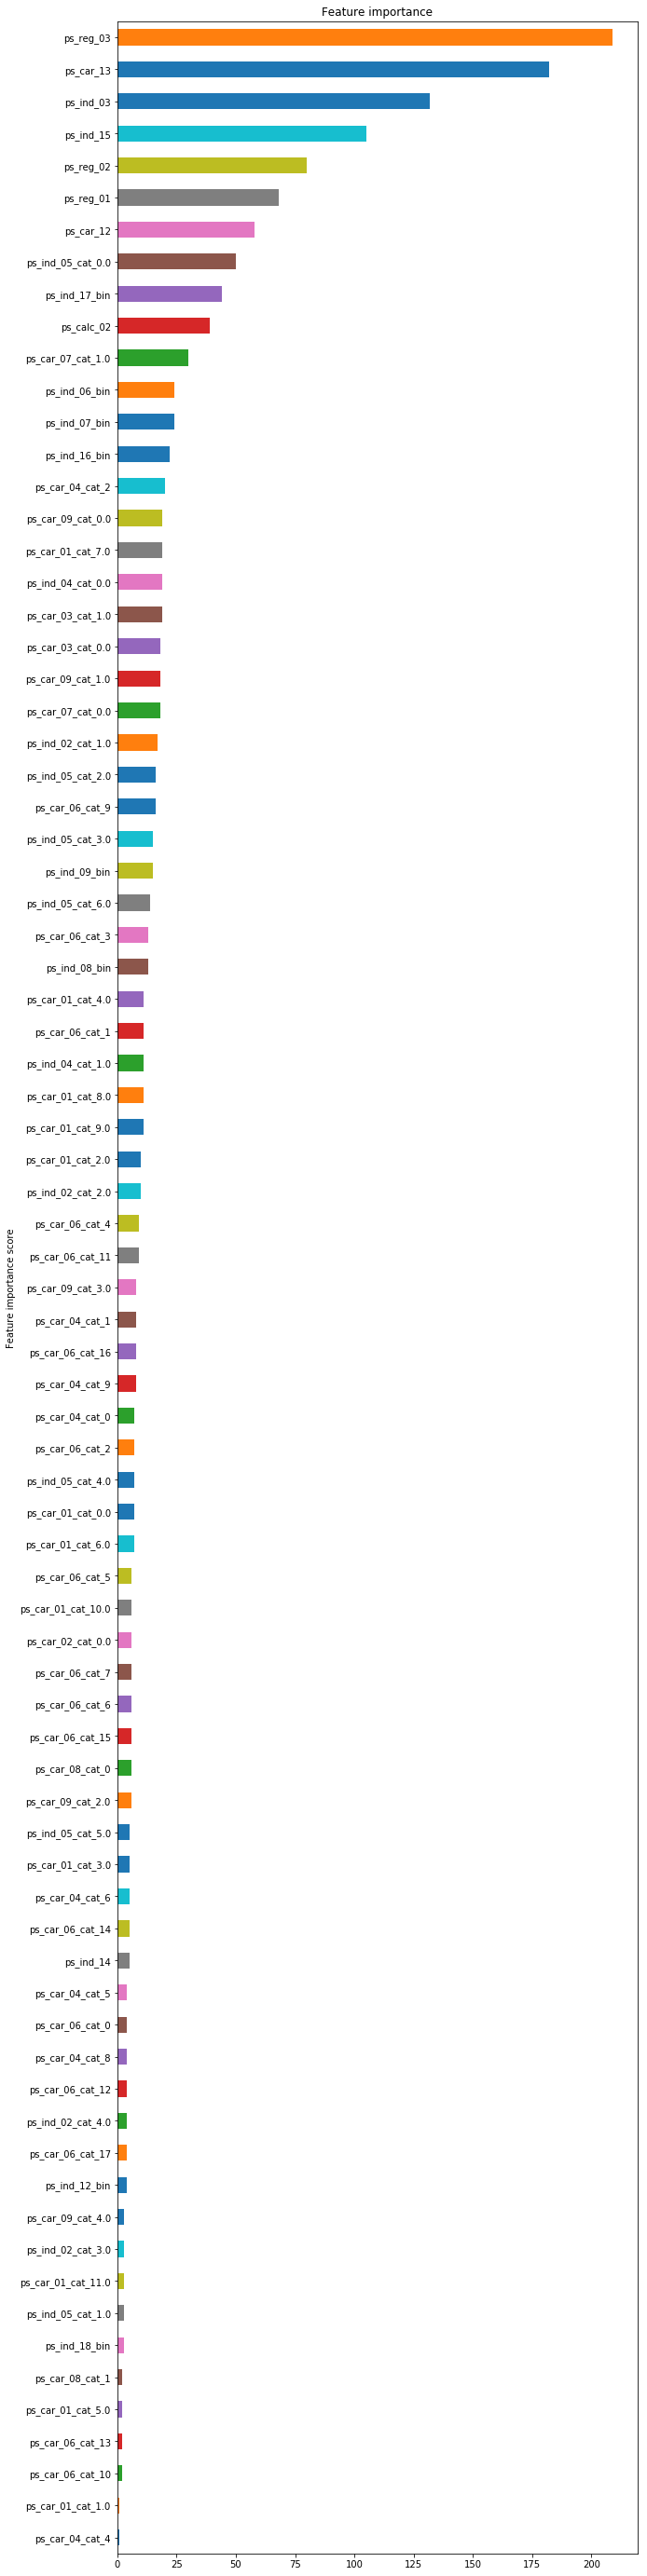

Wall time: 1min 22s


In [39]:
%%time
#Choose all predictors except target & IDcols
xgb2 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'gpu:binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    seed=1223)
alg2 = modelfit(xgb2, train, val)

# Step2

In [19]:
%%time
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
xgb_param3 = {
    'learning_rate':0.1, 
    'n_estimators':200,
    'max_depth':3, 
    'min_child_weight':1,
    'subsample':0.8, 
    'colsample_bytree':0.8,
    'objective': 'gpu:binary:logistic',
    'nthread':4,
    'scale_pos_weight':1, 
    'tree_method':'gpu_hist', 
    'predictor':'gpu_predictor'
}
gsearch3 = param_tune(train, param_test3, xgb_param3)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.0min finished


Wall time: 1min 7s


In [20]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63732, std: 0.00341, params: {'gamma': 0.0},
  mean: 0.63732, std: 0.00341, params: {'gamma': 0.1},
  mean: 0.63732, std: 0.00341, params: {'gamma': 0.2},
  mean: 0.63732, std: 0.00341, params: {'gamma': 0.3},
  mean: 0.63732, std: 0.00341, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.6373187691832332)

# Step3

In [21]:
%%time
param_test4 = {
    'subsample' : [i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
xgb_param4 = {
    'learning_rate':0.1, 
    'n_estimators':200,
    'max_depth':3, 
    'min_child_weight':1,
    'gamma':0,
    'objective':'gpu:binary:logistic',
    'nthread':4,
    'scale_pos_weight':1, 
    'tree_method':'gpu_hist', 
    'predictor':'gpu_predictor'
}
gsearch4 = param_tune(train, param_test4, xgb_param4)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  3.4min finished


Wall time: 3min 27s


In [22]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63743, std: 0.00336, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.63713, std: 0.00299, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.63697, std: 0.00328, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.63696, std: 0.00336, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.63765, std: 0.00316, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.63749, std: 0.00306, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.63643, std: 0.00300, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.63746, std: 0.00294, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.63760, std: 0.00282, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.63739, std: 0.00283, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.63732, std: 0.00341, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.63709, std: 0.00332, params: {'colsample_bytree': 0.8, 'subsample'

[0]	train-auc:0.581926+0.0024909	test-auc:0.579901+0.00663395
[1]	train-auc:0.603022+0.00431451	test-auc:0.598451+0.00562538
[2]	train-auc:0.608299+0.00149707	test-auc:0.604574+0.00653231
[3]	train-auc:0.611262+0.00257031	test-auc:0.6076+0.00555422
[4]	train-auc:0.61329+0.00146415	test-auc:0.60968+0.00453889
[5]	train-auc:0.614373+0.00108137	test-auc:0.611003+0.00629852
[6]	train-auc:0.615973+0.00107202	test-auc:0.612595+0.00650414
[7]	train-auc:0.617109+0.000820082	test-auc:0.613053+0.00684229
[8]	train-auc:0.61785+0.000713518	test-auc:0.613631+0.00608164
[9]	train-auc:0.617741+0.000691404	test-auc:0.613371+0.00625263
[10]	train-auc:0.618185+0.000579146	test-auc:0.61354+0.00570108
[11]	train-auc:0.619369+0.000668492	test-auc:0.61456+0.00593343
[12]	train-auc:0.619365+0.000630717	test-auc:0.614275+0.00507524
[13]	train-auc:0.619108+0.000663058	test-auc:0.613884+0.00545828
[14]	train-auc:0.619451+0.000350744	test-auc:0.614181+0.00513495
[15]	train-auc:0.620254+0.000747933	test-auc:0.615

[128]	train-auc:0.651397+0.000808372	test-auc:0.635407+0.00399489
[129]	train-auc:0.651546+0.000823679	test-auc:0.635481+0.00398022
[130]	train-auc:0.651723+0.000853622	test-auc:0.635569+0.00397114
[131]	train-auc:0.6519+0.000835483	test-auc:0.635574+0.00390819
[132]	train-auc:0.652013+0.000789419	test-auc:0.635596+0.00391771
[133]	train-auc:0.652168+0.000748573	test-auc:0.635576+0.00395182
[134]	train-auc:0.652258+0.000725447	test-auc:0.635568+0.00396023
[135]	train-auc:0.652402+0.00074577	test-auc:0.635544+0.00392584
[136]	train-auc:0.652485+0.000761269	test-auc:0.635543+0.00395651
[137]	train-auc:0.652673+0.000769484	test-auc:0.635522+0.00396177
[138]	train-auc:0.652794+0.000754252	test-auc:0.635571+0.00399136
[139]	train-auc:0.652902+0.000748353	test-auc:0.635544+0.00401459
[140]	train-auc:0.653044+0.00072943	test-auc:0.635576+0.00408904
[141]	train-auc:0.653174+0.000765231	test-auc:0.635576+0.00415919
[142]	train-auc:0.653276+0.000772482	test-auc:0.635585+0.00418091
[143]	train-au

[253]	train-auc:0.663878+0.000797931	test-auc:0.636872+0.00421926
[254]	train-auc:0.663946+0.000792933	test-auc:0.636828+0.00420639
[255]	train-auc:0.664031+0.00079129	test-auc:0.636805+0.00422965
[256]	train-auc:0.664095+0.000822566	test-auc:0.636801+0.00424665
[257]	train-auc:0.664175+0.000855102	test-auc:0.636813+0.00416753
[258]	train-auc:0.664266+0.000840375	test-auc:0.636826+0.00418463
[259]	train-auc:0.664347+0.00082952	test-auc:0.636824+0.00412785
[260]	train-auc:0.664415+0.000818929	test-auc:0.636792+0.00415156
[261]	train-auc:0.664471+0.000805051	test-auc:0.636815+0.00413439
[262]	train-auc:0.664532+0.000798259	test-auc:0.636817+0.00408694
[263]	train-auc:0.664639+0.000809468	test-auc:0.636792+0.004126
[264]	train-auc:0.664711+0.000792531	test-auc:0.636849+0.00406466
[265]	train-auc:0.664815+0.000740258	test-auc:0.636784+0.00404484
[266]	train-auc:0.664935+0.000730935	test-auc:0.636824+0.00407909
[267]	train-auc:0.665023+0.000740795	test-auc:0.636801+0.0040978
[268]	train-auc

C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report[train data]
Accuracy : 0.9636
AUC Score (Train): 0.663001

Model Report[validation data]
Accuracy : 0.9633
AUC Score (Train): 0.643148
Gini: 0.13790, Max Gini: 0.48166, Normlization Gini: 0.28630


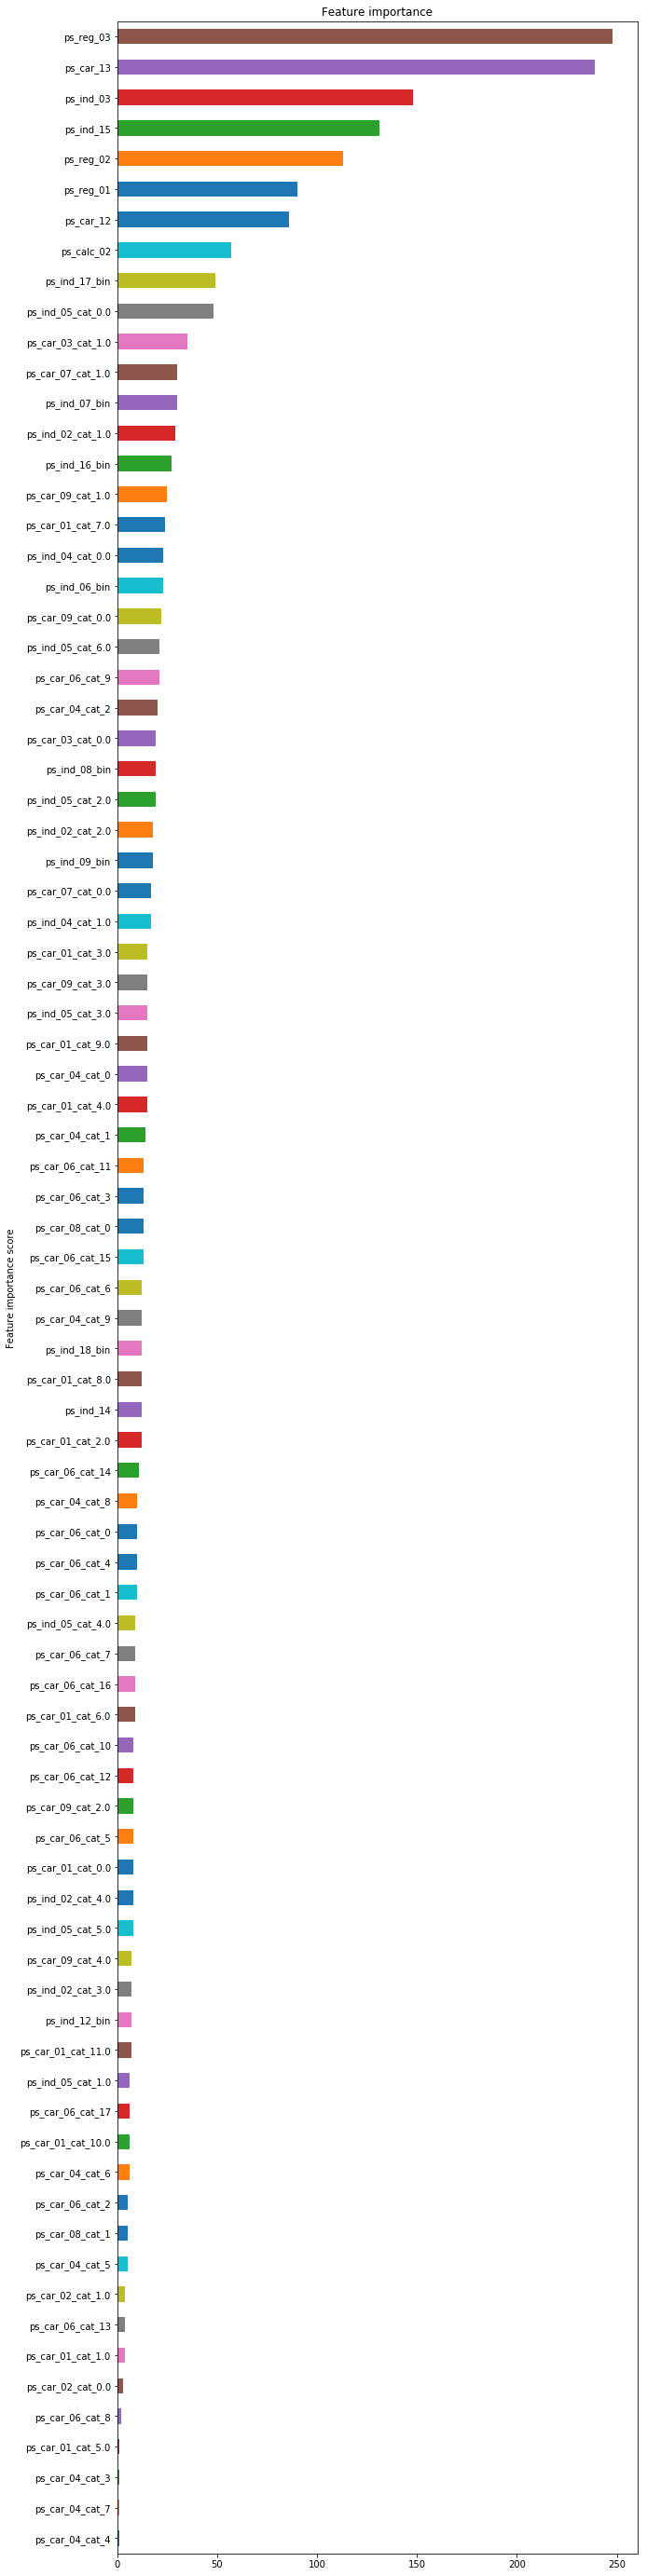

Wall time: 1min 36s


In [23]:
%%time
xgb3 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample= 0.7,
    colsample_bytree=0.6,
    objective= 'gpu:binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    seed=1223)
alg3 = modelfit(xgb3, train, val)

# Step4

In [24]:
%%time
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
xgb_param5 = {
    'learning_rate':0.1, 
    'n_estimators':200,
    'max_depth':3, 
    'min_child_weight':1,
    'subsample':0.7,
    'colsample_bytree':0.6,
    'gamma':0,
    'objective':'gpu:binary:logistic',
    'nthread':4,
    'scale_pos_weight':1, 
    'tree_method':'gpu_hist', 
    'predictor':'gpu_predictor'
}
gsearch5 = param_tune(train, param_test5, xgb_param5)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.0min finished


Wall time: 1min 7s


In [25]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63717, std: 0.00305, params: {'reg_alpha': 1e-05},
  mean: 0.63689, std: 0.00307, params: {'reg_alpha': 0.01},
  mean: 0.63701, std: 0.00290, params: {'reg_alpha': 0.1},
  mean: 0.63707, std: 0.00295, params: {'reg_alpha': 1},
  mean: 0.63268, std: 0.00303, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.6371729444526572)

In [29]:
%%time
param_test6 = {
 'reg_alpha':[1e-10, 1e-07, 1e-05]
}
xgb_param6 = {
    'learning_rate':0.1, 
    'n_estimators':200,
    'max_depth':3, 
    'min_child_weight':1,
    'subsample':0.7,
    'colsample_bytree':0.6,
    'gamma':0,
    'objective':'gpu:binary:logistic',
    'nthread':4,
    'scale_pos_weight':1, 
    'tree_method':'gpu_hist', 
    'predictor':'gpu_predictor'
}
gsearch6 = param_tune(train, param_test6, xgb_param6)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   39.0s finished


Wall time: 44.1 s


In [30]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63713, std: 0.00299, params: {'reg_alpha': 1e-10},
  mean: 0.63713, std: 0.00299, params: {'reg_alpha': 1e-07},
  mean: 0.63717, std: 0.00305, params: {'reg_alpha': 1e-05}],
 {'reg_alpha': 1e-05},
 0.6371729444526572)

In [34]:
%%time
param_test7 = {
 'reg_alpha':[20, 25, 30]
}
xgb_param7 = {
    'learning_rate':0.1, 
    'n_estimators':200,
    'max_depth':4, 
    'min_child_weight':1,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'gamma':0,
    'objective':'gpu:binary:logistic',
    'nthread':4,
    'scale_pos_weight':1, 
    'tree_method':'gpu_hist', 
    'predictor':'gpu_predictor'
}
gsearch7 = param_tune(train, param_test7, xgb_param7)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  1.7min finished


Wall time: 1min 49s


In [35]:
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63713, std: 0.00272, params: {'reg_alpha': 20},
  mean: 0.63739, std: 0.00279, params: {'reg_alpha': 25},
  mean: 0.63732, std: 0.00271, params: {'reg_alpha': 30}],
 {'reg_alpha': 25},
 0.6373894987188087)

In [36]:
%%time
param_test8 = {
 'reg_alpha':[23, 25, 27]
}
xgb_param8 = {
    'learning_rate':0.1, 
    'n_estimators':200,
    'max_depth':4, 
    'min_child_weight':1,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'gamma':0,
    'objective':'gpu:binary:logistic',
    'nthread':4,
    'scale_pos_weight':1, 
    'tree_method':'gpu_hist', 
    'predictor':'gpu_predictor'
}
gsearch8 = param_tune(train, param_test8, xgb_param8)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  1.7min finished


Wall time: 1min 48s


In [105]:
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63747, std: 0.00337, params: {'reg_alpha': 17},
  mean: 0.63742, std: 0.00307, params: {'reg_alpha': 20},
  mean: 0.63748, std: 0.00317, params: {'reg_alpha': 23}],
 {'reg_alpha': 23},
 0.6374845327143472)

In [39]:
%%time
param_test9 = {
 'reg_alpha':[21, 22, 23]
}
xgb_param9 = {
    'learning_rate':0.1, 
    'n_estimators':200,
    'max_depth':4, 
    'min_child_weight':1,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'gamma':0,
    'objective':'gpu:binary:logistic',
    'nthread':4,
    'scale_pos_weight':1, 
    'tree_method':'gpu_hist', 
    'predictor':'gpu_predictor'
}
gsearch9 = param_tune(train, param_test9, xgb_param9)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  1.7min finished


Wall time: 1min 48s


In [40]:
gsearch9.grid_scores_, gsearch9.best_params_, gsearch9.best_score_

C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63739, std: 0.00280, params: {'reg_alpha': 21},
  mean: 0.63741, std: 0.00266, params: {'reg_alpha': 22},
  mean: 0.63733, std: 0.00315, params: {'reg_alpha': 23}],
 {'reg_alpha': 22},
 0.6374051710527934)

#### optimized parameters for all features

xgb4 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=2000,
    max_depth=3,
    min_child_weight=3,
    gamma=0,
    subsample= 0.7,
    colsample_bytree=0.9,
    reg_alpha=1,
    nthread=4,
    scale_pos_weight=1,
    objective= 'gpu:binary:logistic',
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    seed=1223)
    
#### optimized parameters for drop features similarly same mean and median by target

xgb4 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=2000,
    max_depth=4,
    min_child_weight=6,
    gamma=0,
    subsample= 0.8,
    colsample_bytree=0.8,
    reg_alpha=23,
    nthread=4,
    scale_pos_weight=1,
    objective= 'gpu:binary:logistic',
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    seed=1223)
    
#### optimized parameters for drop features similarly same mean and median and count by target

xgb4 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=2000,
    max_depth=4,
    min_child_weight=1,
    gamma=0,
    subsample= 0.7,
    colsample_bytree=0.7,
    reg_alpha=22,
    nthread=4,
    scale_pos_weight=1,
    objective= 'gpu:binary:logistic',
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    seed=1223)
    
#### optimized parameters for drop some integer, binary, category features

xgb4 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=2000,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample= 0.7,
    colsample_bytree=0.6,
    reg_alpha=1e-05,
    objective= 'gpu:binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    seed=1223)

[0]	train-auc:0.581926+0.0024909	test-auc:0.579901+0.00663395
[1]	train-auc:0.601382+0.00480214	test-auc:0.59804+0.00334437
[2]	train-auc:0.608923+0.00189369	test-auc:0.605676+0.00585404
[3]	train-auc:0.611345+0.00137602	test-auc:0.608473+0.00466937
[4]	train-auc:0.613147+0.00214715	test-auc:0.60902+0.00519786
[5]	train-auc:0.615293+0.00153244	test-auc:0.610129+0.00466681
[6]	train-auc:0.616593+0.00109519	test-auc:0.611095+0.00456803
[7]	train-auc:0.617369+0.00108098	test-auc:0.612224+0.00487875
[8]	train-auc:0.617792+0.000931205	test-auc:0.612396+0.00461584
[9]	train-auc:0.618161+0.000963262	test-auc:0.61239+0.00424911
[10]	train-auc:0.618857+0.00131923	test-auc:0.613437+0.00465807
[11]	train-auc:0.618594+0.0011615	test-auc:0.612913+0.00485671
[12]	train-auc:0.618918+0.000665659	test-auc:0.613532+0.00520748
[13]	train-auc:0.619151+0.000750551	test-auc:0.613845+0.00549365
[14]	train-auc:0.619465+0.000693545	test-auc:0.614276+0.00528041
[15]	train-auc:0.619197+0.000563146	test-auc:0.614

[128]	train-auc:0.65146+0.000892513	test-auc:0.636069+0.00394744
[129]	train-auc:0.651595+0.000908936	test-auc:0.636078+0.00391364
[130]	train-auc:0.651709+0.000886874	test-auc:0.636131+0.00395064
[131]	train-auc:0.651834+0.000897765	test-auc:0.6361+0.00399059
[132]	train-auc:0.651931+0.00091922	test-auc:0.636063+0.00407028
[133]	train-auc:0.65206+0.000882732	test-auc:0.63609+0.00410879
[134]	train-auc:0.652137+0.000852553	test-auc:0.636088+0.00412513
[135]	train-auc:0.652301+0.000878242	test-auc:0.636152+0.00408973
[136]	train-auc:0.652436+0.000895515	test-auc:0.636199+0.00409447
[137]	train-auc:0.652555+0.000926061	test-auc:0.636123+0.00410827
[138]	train-auc:0.652675+0.000920658	test-auc:0.636169+0.00409358
[139]	train-auc:0.652801+0.000938521	test-auc:0.636229+0.00404289
[140]	train-auc:0.652898+0.000944317	test-auc:0.63623+0.00408139
[141]	train-auc:0.652988+0.00095582	test-auc:0.636266+0.00402571
[142]	train-auc:0.653071+0.000975253	test-auc:0.636267+0.00401579
[143]	train-auc:0.

C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\wogur\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report[train data]
Accuracy : 0.9637
AUC Score (Train): 0.655875

Model Report[validation data]
Accuracy : 0.9633
AUC Score (Train): 0.643022
Gini: 0.13778, Max Gini: 0.48166, Normlization Gini: 0.28604


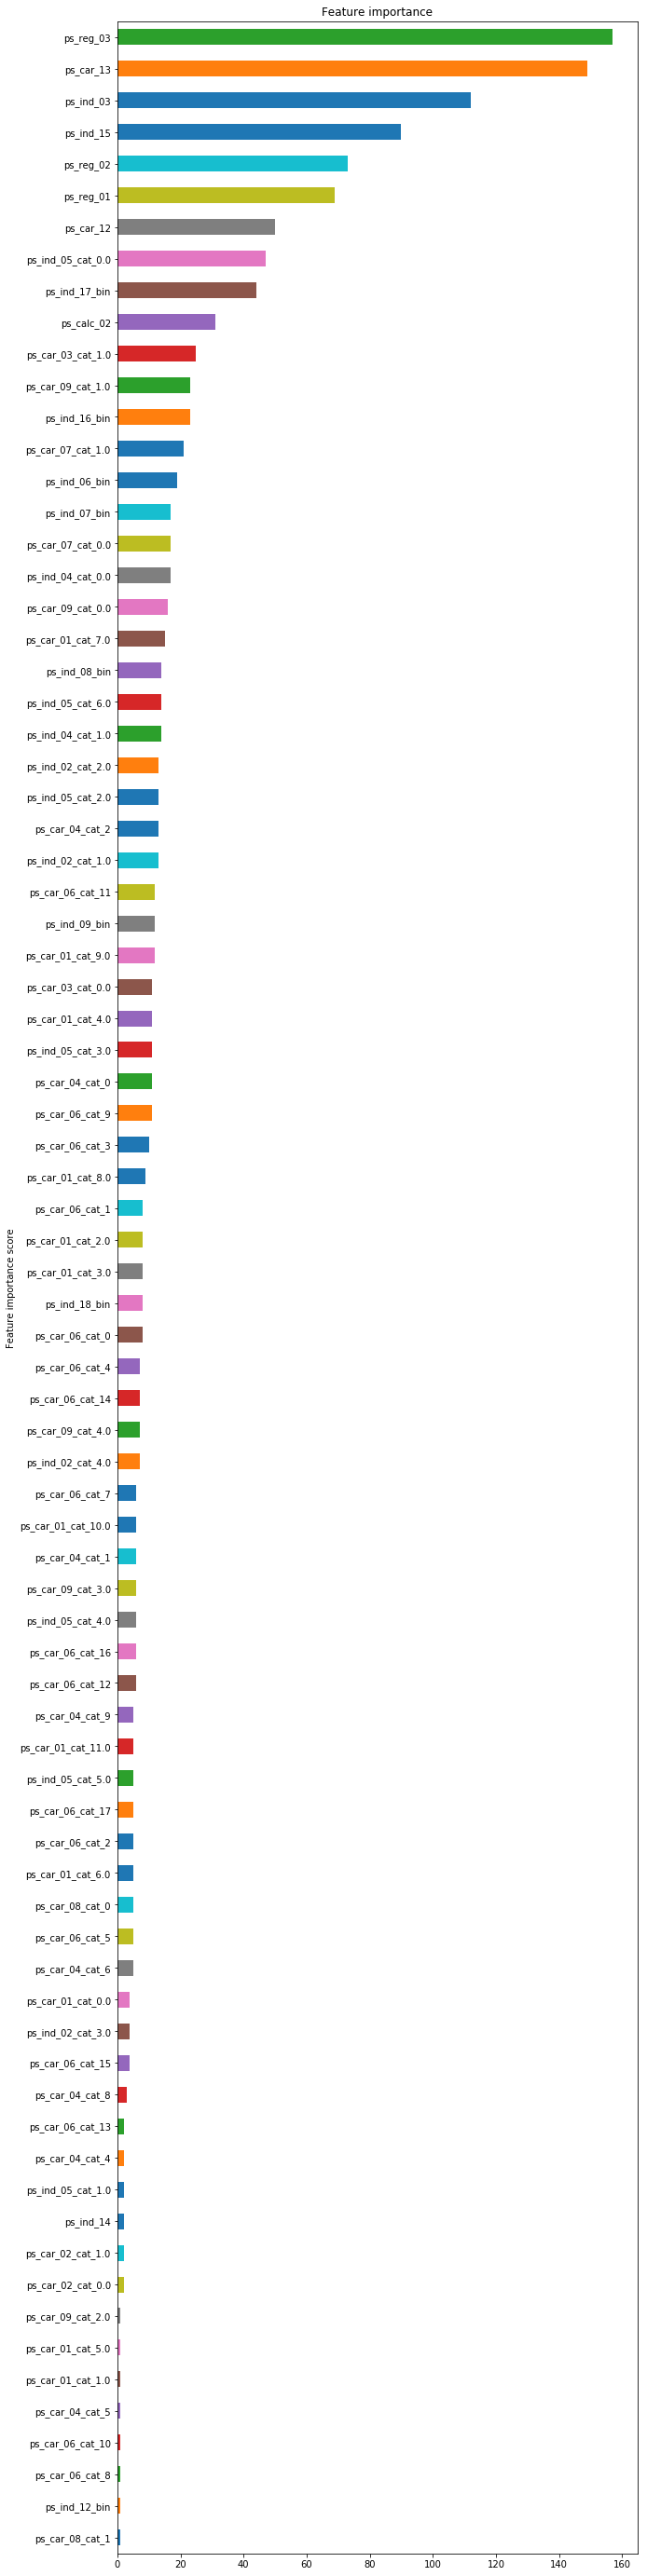

Wall time: 42.6 s


In [21]:
%%time
xgb4 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=2000,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample= 0.7,
    colsample_bytree=0.6,
    reg_alpha=1e-05,
    objective= 'gpu:binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    seed=1223)
alg4 = modelfit(xgb4, train, val)

In [76]:
filename = 'f_score4.csv'

value = pd.Series(alg4.get_booster().get_fscore()).sort_values(ascending=False)
ranking = pd.DataFrame({'id':value.index, 'value':value, 'rank':list(range(1,len(value)+1))})
idx_df = pd.DataFrame({'id':train_origin.columns[2:], 'idx':list(range(1,len(train_origin.columns[2:])+1))})
f_score_df = pd.merge(ranking,idx_df, how='right')
f_score_df = f_score_df.sort_values(by='idx')
f_score_df.to_csv('../../input/' + filename)
f_score_df

,id,value,rank,idx
83,ps_ind_01,NaN,NaN,1
2,ps_ind_03,148.0,3.0,2
18,ps_ind_06_bin,23.0,19.0,3
12,ps_ind_07_bin,30.0,13.0,4
24,ps_ind_08_bin,19.0,25.0,5
27,ps_ind_09_bin,18.0,28.0,6
84,ps_ind_10_bin,NaN,NaN,7
85,ps_ind_11_bin,NaN,NaN,8
65,ps_ind_12_bin,7.0,66.0,9
86,ps_ind_13_bin,NaN,NaN,10


## 6. Submission

In [77]:
predictors = [x for x in train_t.columns if x not in ['id','target']]
alg4.fit(train_t[predictors], train_t['target'], eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=306,
       n_jobs=1, nthread=4, objective='gpu:binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=1e-05,
       reg_lambda=1, scale_pos_weight=1, seed=1223, silent=True,
       subsample=0.7, tree_method='gpu_hist')

In [78]:
test_pred = alg4.predict_proba(test)[:,1]

In [79]:
filename = 'submission9.csv'
pd.DataFrame({'id':test_idx, 'target':test_pred}).to_csv('../../input/' + filename,index=False)